In [2]:
import rospy
from sensor_msgs.msg import Image, CameraInfo
from std_srvs.srv import Trigger
import clover.srv

In [110]:
rospy.init_node('testNB', anonymous=True)
def capture():
    return rospy.wait_for_message('/main_camera/image_raw', Image, timeout=1.)

def camera_info():
    return rospy.wait_for_message('/main_camera/camera_info', CameraInfo, timeout=1.)

get_telemetry = rospy.ServiceProxy('get_telemetry', clover.srv.GetTelemetry)
navigate = rospy.ServiceProxy('navigate', clover.srv.Navigate)
navigate_global = rospy.ServiceProxy('navigate_global', clover.srv.NavigateGlobal)
set_position = rospy.ServiceProxy('set_position', clover.srv.SetPosition)
set_velocity = rospy.ServiceProxy('set_velocity', clover.srv.SetVelocity)
set_attitude = rospy.ServiceProxy('set_attitude', clover.srv.SetAttitude)
set_rates = rospy.ServiceProxy('set_rates', clover.srv.SetRates)
land = rospy.ServiceProxy('land', Trigger)

def take_off():
    set_position(z=1.5, frame_id='map', auto_arm=True)

In [5]:
import cv2, numpy as np
from cv_bridge import CvBridge
from matplotlib import pyplot as plt

bridge = CvBridge()
def image():
    msg = capture()
    return bridge.imgmsg_to_cv2(msg,desired_encoding='bgr8')
def show(img, show=True, **kwargs):
    plt.imshow(img[...,::-1], **kwargs)
    if show:
        plt.show()

In [6]:
from importlib import reload
import drone_control
reload(drone_control)

camera_matrix = np.array(camera_info().K).reshape((3,3))
K_inv = np.linalg.inv(camera_matrix)
K_inv

array([[ 0.01082538,  0.        , -1.73747329],
       [ 0.        ,  0.01082538, -1.30445814],
       [ 0.        ,  0.        ,  1.        ]])

In [7]:
def image_below():
    img = image()
    telemetry = get_telemetry()
    rotation, translation, velocity = drone_control.parse_telemetry(telemetry)
    img_below, _ = drone_control.project_below(img, rotation, translation, K_inv)
    center = -translation[:2] * drone_control.RESOLUTION
    size = np.array(img_below.shape[:2][::-1])
    min_pt = np.round(center - size/2).astype(int)
    max_pt = min_pt + size
    roi = (min_pt, max_pt)
    return img_below, roi

In [60]:
stitcher = cv2.Stitcher_create(mode=cv2.STITCHER_SCANS)

(array([-128,  -89]), array([109,  94]))

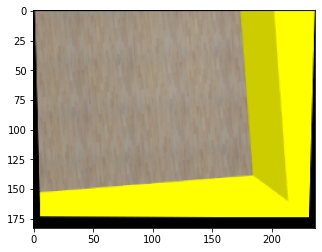

In [70]:
img1, roi1 = image_below()
show(img1)
roi1

(array([-231, -190]), array([11, -6]))

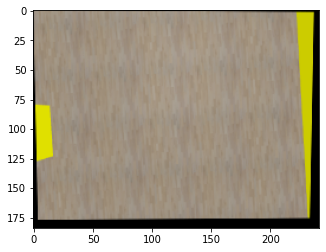

In [69]:
img2, roi2 = image_below()
show(img2)
roi2

(array([-168, -239]), array([ 66, -62]))

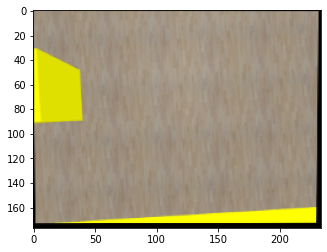

In [68]:
img3, roi3 = image_below()
show(img3)
roi3

In [73]:
status, img = stitcher.stitch([img1[:100,:100], img2[:100,:100], img3[:100,:100]])
if status == 0:
    show(img)
else:
    print(status)

1


In [71]:
min_pts = np.stack([roi1[0], roi2[0], roi3[0]])
max_pts = np.stack([roi1[1], roi2[1], roi3[1]])

min_pt = np.min(min_pts, axis=0)
max_pt = np.max(max_pts, axis=0)

print(min_pt, max_pt)

[-231 -239] [109  94]


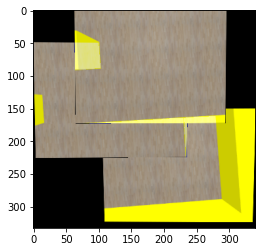

In [72]:
w,h = np.round(max_pt - min_pt).astype(int)
img_combined = np.zeros((h, w, 3), dtype=np.uint8)
for img,roi in [(img1,roi1), (img2,roi2), (img3,roi3)]:
    mask = img > 0
    pt0, pt1 = roi
    x0, y0 = pt0 - min_pt
    x1, y1 = pt1 - min_pt
    view = img_combined[y0:y1,x0:x1]
    np.putmask(view, mask, img)
show(img_combined)

In [54]:
arr = np.arange(20).reshape((4,5))
v = arr[:4,:3]
np.putmask(v, np.ones((4,3),dtype=bool), 1)
arr

array([[ 1,  1,  1,  3,  4],
       [ 1,  1,  1,  8,  9],
       [ 1,  1,  1, 13, 14],
       [ 1,  1,  1, 18, 19]])

In [8]:
def image_and_below():
    img = image()
    telemetry = get_telemetry()
    rotation, translation, velocity = drone_control.parse_telemetry(telemetry)
    img_below, H = drone_control.project_below(img, rotation, translation, K_inv)
    return img, img_below, H, translation

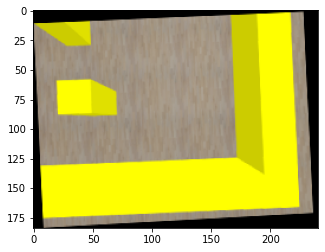

In [129]:
img1, img1_below, H1, pos1 = image_and_below()
show(img1_below)

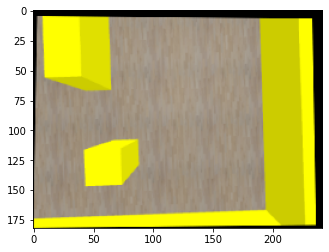

In [130]:
img2, img2_below, H2, pos2 = image_and_below()
show(img2_below)

In [9]:
# https://towardsdatascience.com/image-panorama-stitching-with-opencv-2402bde6b46c
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf', 'brisk', 'orb'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [10]:
def testMethod(imgA, imgB, method=None):
    kpsA, featuresA = detectAndDescribe(imgA, method=method)
    kpsB, featuresB = detectAndDescribe(imgB, method=method)

    # display the keypoints and features detected on both images
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
    fig.suptitle(method)
    ax1.imshow(cv2.drawKeypoints(imgA,kpsA,None,color=(0,255,0))[...,::-1])
    ax1.set_xlabel("(a)", fontsize=14)
    ax2.imshow(cv2.drawKeypoints(imgB,kpsB,None,color=(0,255,0))[...,::-1])
    ax2.set_xlabel("(b)", fontsize=14)

    plt.show()

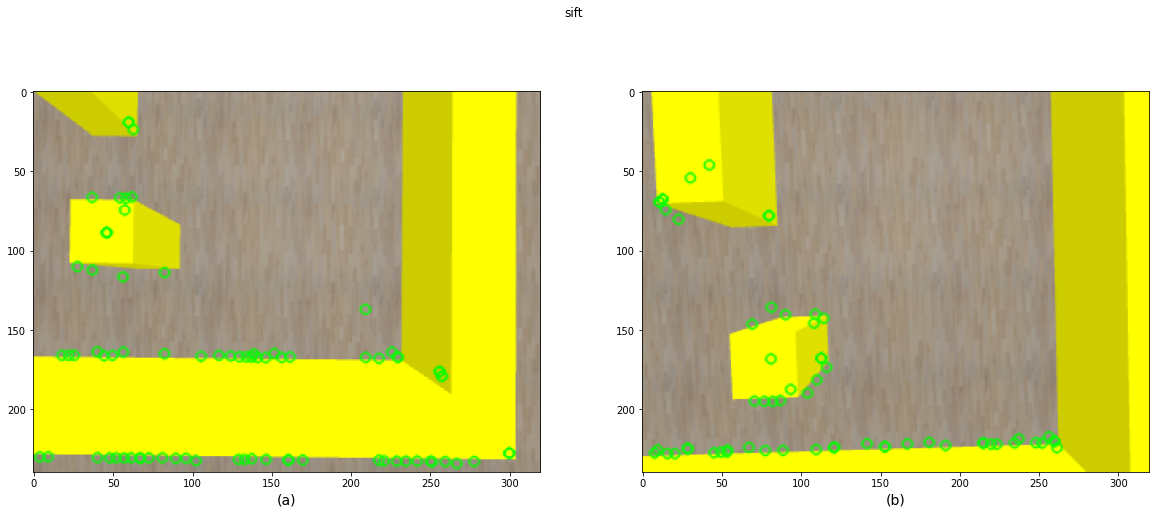

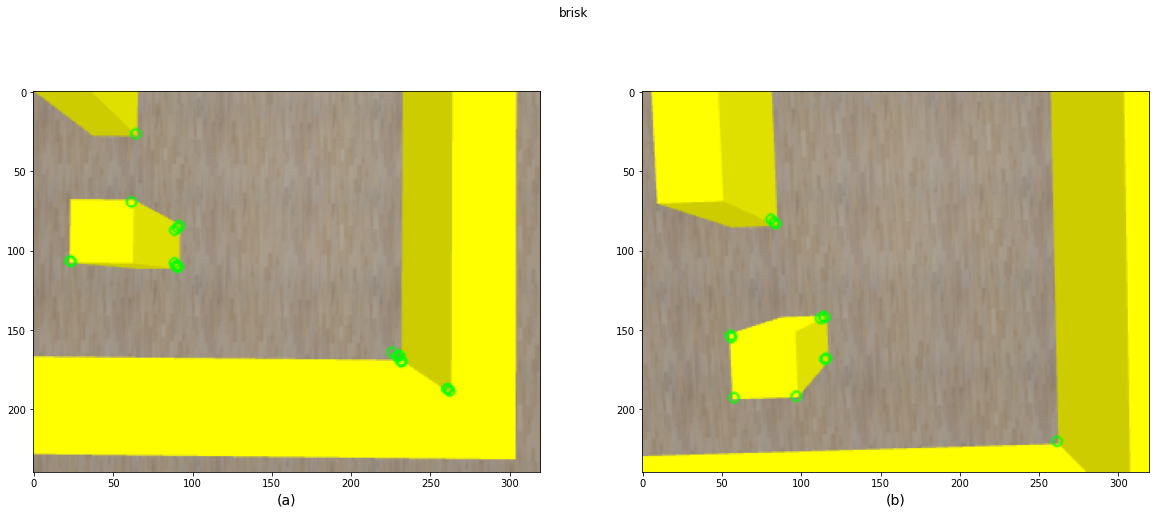

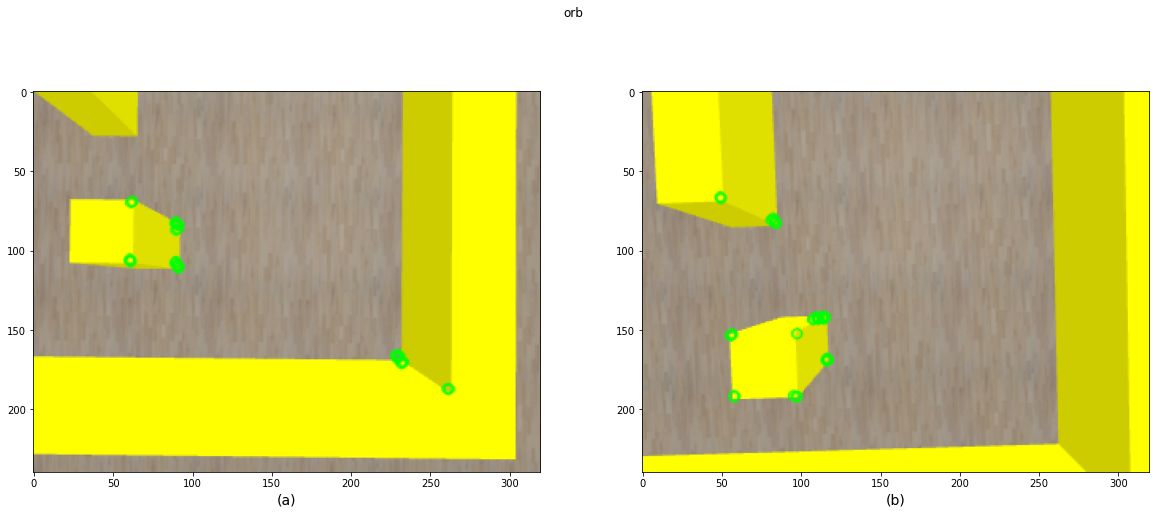

In [131]:
testMethod(img1, img2, method='sift')
#testMethod(img1, img2, method='surf')
testMethod(img1, img2, method='brisk')
testMethod(img1, img2, method='orb')

In [11]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Raw matches (knn): 20
Filtered matches: 2


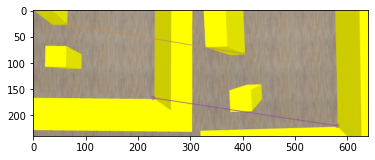

In [132]:
kpsA, featuresA = detectAndDescribe(img1, method='brisk')
kpsB, featuresB = detectAndDescribe(img2, method='brisk')

matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method='brisk')
print("Filtered matches:", len(matches))
matches_sel = np.random.choice(matches,100) if len(matches) > 100 else matches
img_matches = cv2.drawMatches(img1,kpsA,img2,kpsB,matches_sel,
                        None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show(img_matches)

In [133]:
kpsA_arr = np.float32([kp.pt for kp in kpsA])
kpsB_arr = np.float32([kp.pt for kp in kpsB])

matches_arr = np.array([(m.queryIdx, m.trainIdx) for m in matches])

kpsA_matched = kpsA_arr[matches_arr[:,0]]
kpsB_matched = kpsB_arr[matches_arr[:,1]]

kpsA_hom = cv2.convertPointsToHomogeneous(kpsA_matched)[:,0,:]
kpsB_hom = cv2.convertPointsToHomogeneous(kpsB_matched)[:,0,:]

kpsA_tf_hom = (H1 @ kpsA_hom.T).T
kpsB_tf_hom = (H2 @ kpsB_hom.T).T

kpsA_tf = cv2.convertPointsFromHomogeneous(kpsA_tf_hom)[:,0,:]
kpsB_tf = cv2.convertPointsFromHomogeneous(kpsB_tf_hom)[:,0,:]

translation_est = (pos2 - pos1)[:2][::-1] * drone_control.RESOLUTION
translations = kpsB_tf - kpsA_tf
translation_err = np.linalg.norm(translations - translation_est, axis=-1)

print(translation_est)
print(translations)

translation_err

[48.59843049 87.87010899]
[[16.35276508 37.2090592 ]
 [22.75185354 42.45304122]]


array([60.0526844 , 52.25663198])

In [134]:
MAX_DUPES = 5
score = 1 / translation_err
score_norm = score / np.max(score) * MAX_DUPES
score_floor = np.floor(score_norm).astype(int)
score_offs = score_norm - score_floor
score_rand = np.random.rand(len(score_offs)) < score_offs
score_final = score_floor + score_rand
score_final

array([4, 5])

In [135]:
kps = np.stack([kpsA_tf, kpsB_tf], axis=0)
kps_biased = np.repeat(kps, score_final, axis=1)
print(kps.shape[1],'->',kps_biased.shape[1])

2 -> 9


In [136]:
M, status = cv2.estimateAffinePartial2D(kps_biased[0], kps_biased[1])
print(status)
M

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


array([[ 1.05333178e+00, -1.60842640e-03,  1.38566986e+01],
       [ 1.60842640e-03,  1.05333178e+00,  3.56345913e+01]])

In [103]:
mask = status[:,0].astype(bool)
kps_masked = kps_biased[:,mask]
matches_np = np.stack([np.arange(np.count_nonzero(mask)),np.arange(np.count_nonzero(mask))])
img_matches = cv2.drawMatches(img1_below,kps_masked[0],img2_below,kps_masked[1],matches_np,
                        None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show(img_matches)

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - Expected cv::KeyPoint for argument 'keypoints1'
>  - Expected cv::KeyPoint for argument 'keypoints1'
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)


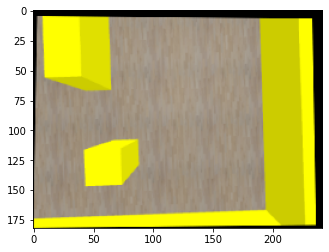

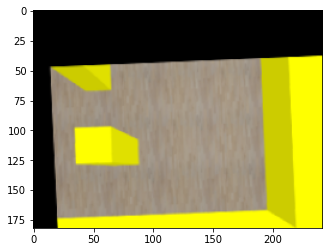

In [137]:
img1_in_2 = cv2.warpAffine(img1_below, M, img2_below.shape[:2][::-1])
show(img2_below)
plt.show()
show(img1_in_2)

In [12]:
def matchKeyPointsRaw(featuresA, featuresB, method, k=1):
    bf = createMatcher(method, crossCheck=False)
    if k == 1:
        return bf.match(featuresA,featuresB)
    else:
        return bf.knnMatch(featuresA, featuresB, k)

def matchPoints(kpsA, kpsB, matches):
    matches_arr = np.array(matches)
    matches_idx = np.array([(m.queryIdx, m.trainIdx) for m in matches_arr.flat])
    matches_dist = np.array([m.distance for m in matches_arr.flat])
    
    kpsA_arr = cv2.KeyPoint.convert(kpsA)
    kpsB_arr = cv2.KeyPoint.convert(kpsB)

    kpsA_matched = kpsA_arr[matches_idx[:,0]]
    kpsB_matched = kpsB_arr[matches_idx[:,1]]

    kps_matched = np.stack([kpsA_matched, kpsB_matched])

    return kps_matched, matches_dist

Raw matches (knn): 20


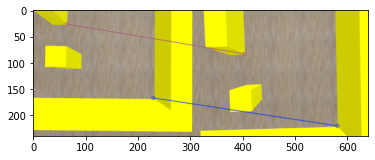

array([48.59843049, 87.87010899])

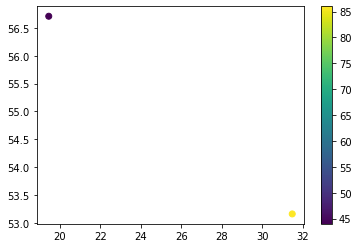

In [139]:
matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method='brisk')
img_matches = cv2.drawMatches(img1,kpsA,img2,kpsB,matches,
                        None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show(img_matches)
plt.show()

kps_matched, matches_dist = matchPoints(kpsA, kpsB, matches)
translations = kps_matched[1] - kps_matched[0]
plt.scatter(translations[:,0], translations[:,1], c=matches_dist)
plt.colorbar()
translation_est

In [17]:
filter_yellow = drone_control.Filter(**drone_control.YELLOW_FILTER)
hsv1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
filter = filter_yellow.apply(hsv1)
filter_img = (filter * 255).astype(np.uint8)
show(filter_img)

NameError: name 'img1' is not defined

In [13]:
def blend_centered(imgA, imgB):
    image_sizes = np.array([imgA.shape[:2][::-1], imgB.shape[:2][::-1]])
    out_size = np.max(image_sizes, axis=0)
    out_center = out_size / 2
    in_centers = image_sizes / 2
    tf_centers = out_center - in_centers

    # Create out image
    w, h = out_size
    img_out = np.zeros((h,w,3), dtype=np.uint8)

    # Paste first image
    wA, hA = image_sizes[0]
    xA, yA = np.round(tf_centers[0]).astype(int)
    img_out[yA:yA+hA,xA:xA+wA] = imgA

    # Paste second image, masked
    wB, hB = image_sizes[1]
    xB, yB = np.round(tf_centers[1]).astype(int)
    rangeB = img_out[yB:yB+hB,xB:xB+wB]

    mask = np.sum(imgB, axis=-1) > 0
    mask_broad = np.broadcast_to(mask[...,None], imgB.shape)
    np.putmask(rangeB, mask_broad, imgB)

    return img_out

In [14]:
WALL_HEIGHT=1.0
def image_and_below():
    img = image()
    telemetry = get_telemetry()
    rotation, translation, velocity = drone_control.parse_telemetry(telemetry)

    # Create wall mask
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = filter_yellow.apply(hsv) > 0.5
    mask_broad = np.broadcast_to(mask[...,None], img.shape)

    # Apply mask and split image
    img_ground, img_walls = np.zeros_like(img), np.zeros_like(img)
    np.putmask(img_ground, ~mask_broad, img)
    np.putmask(img_walls, mask_broad, img)

    # Project both at different heights
    img_below_ground, H_ground = drone_control.project_below(img_ground, rotation, translation, camera_matrix, K_inv)
    img_below_wall, H_wall = drone_control.project_below(img_walls, rotation, translation - (0,0,WALL_HEIGHT), camera_matrix, K_inv)

    # Combine both projections
    img_below = blend_centered(img_below_ground, img_below_wall)

    return img, img_below, translation

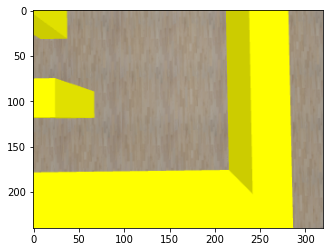

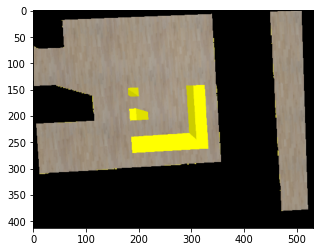

In [408]:
reload(drone_control)
img, img_below, T = image_and_below()
show(img)
show(img_below)

In [322]:
reload(drone_control)
H = drone_control.homogeneous_cam2gnd((0,0,0), (0.,0.,-0.5), K_inv)
drone_control.roi((100,100), H)

(array([0.98240312, 0.3328804 ]), array([2.60620994, 1.95668721]))

In [311]:
from scipy.spatial.transform import Rotation
project_hom = np.array(
    [[1,0,0],
     [0,1,0],
     [0,0,1],
     [0,0,1]])

R_euler = (0,np.pi/8,0)
T_vec = (1,1,-0.5)

rotation = Rotation.from_euler('xyz', R_euler)
R = rotation.as_matrix()
R_inv = R.T
T_vec_inv = R_inv @ T_vec
M_inv = np.concatenate([R_inv, T_vec_inv[:,None]], axis=-1)
H_inv = M_inv @ project_hom @ K_inv

print(M_inv)
print(H_inv)

[[ 0.92387953  0.         -0.38268343  1.11522125]
 [ 0.          1.          0.          1.        ]
 [ 0.38268343  0.          0.92387953 -0.07925633]]
[[ 0.01000135  0.         -0.8726782 ]
 [ 0.          0.01082538 -0.30445814]
 [ 0.00414269  0.          0.17972096]]


In [317]:
pts = np.array([(160,120)])
pts_hom = cv2.convertPointsToHomogeneous(pts)[:,0,:]
pts_tf_hom = (H_inv @ pts_hom.T).T
pts_tf = pts_tf_hom[...,:2] * pts_tf_hom[...,2]
pts_tf

array([[0.61298777, 0.83799138]])

In [306]:
from scipy.spatial.transform import Rotation
project_hom = np.array(
    [[1,0,0],
     [0,1,0],
     [0,0,0],
     [0,0,1]])

R_euler = (0,-np.pi/8,0)
T_vec = np.array((1,1,-0.5))
T = np.concatenate([np.eye(3), -T_vec[:,None]], axis=-1)

rotation = Rotation.from_euler('xyz', R_euler)
R = rotation.as_matrix()
M = R @ T
H = camera_matrix @ M @ project_hom

print(M)
print(H)

[[ 0.92387953  0.         -0.38268343 -1.11522125]
 [ 0.          1.          0.         -1.        ]
 [ 0.38268343  0.          0.92387953  0.07925633]]
[[ 1.46764544e+02  0.00000000e+00 -9.02985019e+01]
 [ 4.61133536e+01  9.23755207e+01 -8.28251324e+01]
 [ 3.82683432e-01  0.00000000e+00  7.92563339e-02]]


In [315]:
pts = np.array([(2.0,1.0)])
pts_hom = cv2.convertPointsToHomogeneous(pts)[:,0,:]
M  @ project_hom @ pts_hom.T

array([[0.34985438],
       [0.        ],
       [1.76850273]])

In [12]:
reload(drone_control)
drone_control.homogeneous_gnd2cam(np.array((0,0,0)),np.array((0,0,0.5)),camera_matrix)

array([[92.37552066,  0.        , 80.25      ],
       [ 0.        , 92.37552066, 60.25      ],
       [ 0.        ,  0.        ,  0.5       ]])

In [15]:
WALL_HEIGHT=1.0
def wall_below():
    img = image()
    telemetry = get_telemetry()
    rotation, translation, velocity = drone_control.parse_telemetry(telemetry)

    # Create wall mask
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = filter_yellow.apply(hsv) > 0.5
    mask_broad = np.broadcast_to(mask[...,None], img.shape)

    # Apply mask and project below
    img[~mask] = (0,0,0)
    img_below, H_inv = drone_control.project_below(img, rotation, translation, camera_matrix, K_inv)

    return img_below, translation

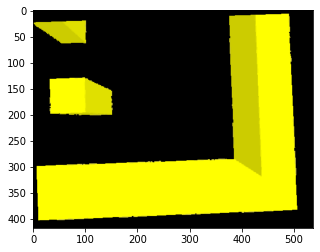

In [18]:
img1, T1 = wall_below()
show(img1)

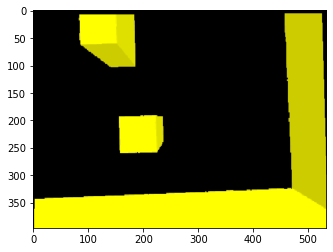

In [19]:
img2, T2 = wall_below()
show(img2)

In [20]:
def augmentFeatures(kptsA, featuresA, kptsB, featuresB, translation_estimate):
    locA = kptsA + translation_estimate
    locB = kptsB

    repsA = featuresA.shape[1] // 2
    repsB = featuresB.shape[1] // 2

    featA = np.repeat(locA.astype(featuresA.dtype), repsA, axis=-1)
    featB = np.repeat(locB.astype(featuresA.dtype), repsB, axis=-1)

    featuresA = np.concatenate([featuresA, featA], axis=-1)
    featuresB = np.concatenate([featuresB, featB], axis=-1)

    return featuresA, featuresB

Raw matches (knn): 139


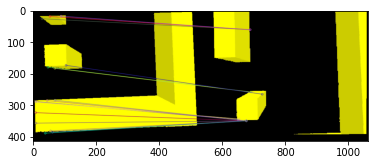

array([109.97698177,  51.6524327 ])

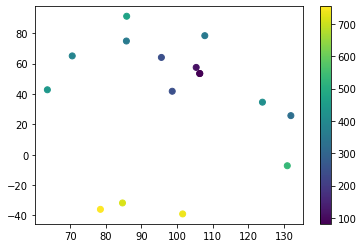

In [534]:
kpsA, featuresA = detectAndDescribe(img1, method='sift')
kpsB, featuresB = detectAndDescribe(img2, method='sift')

kptsA = cv2.KeyPoint.convert(kpsA)
kptsB = cv2.KeyPoint.convert(kpsB)

translation_est = (T2-T1)[:2] * drone_control.RESOLUTION
featuresA, featuresB = augmentFeatures(kptsA, featuresA, kptsB, featuresB, translation_est)

matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.8, method='sift')
img_matches = cv2.drawMatches(img1,kpsA,img2,kpsB,matches,
                        None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show(img_matches)
plt.show()

kps_matched, matches_dist = matchPoints(kpsA, kpsB, matches)
translations = kps_matched[1] - kps_matched[0]
plt.scatter(translations[:,0], translations[:,1], c=matches_dist)
plt.colorbar()

translation_est

In [465]:
MAX_DUPES = 5
score = 1 / matches_dist
score_norm = score / np.max(score) * MAX_DUPES
score_floor = np.floor(score_norm).astype(int)
score_offs = score_norm - score_floor
score_rand = np.random.rand(len(score_offs)) < score_offs
score_final = score_floor + score_rand
score_final

array([1, 4, 1, 4, 5, 1, 0, 1, 1, 2, 0, 0, 1, 2, 1, 1])

In [468]:
kps_biased = np.repeat(kps_matched, score_final, axis=1)
print(kps_matched.shape[1],'->',kps_biased.shape[1])

16 -> 25


In [470]:
M, status = cv2.estimateAffinePartial2D(kps_biased[0], kps_biased[1])
print(np.count_nonzero(status),"/",status.size)
M

14 / 25


array([[ 7.13423368e-02,  3.68642267e-01,  8.19586903e+00],
       [-3.68642267e-01,  7.13423368e-02,  3.26870602e+02]])

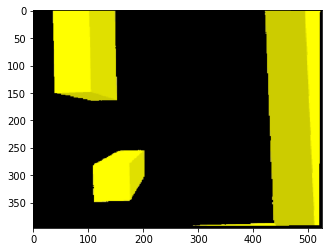

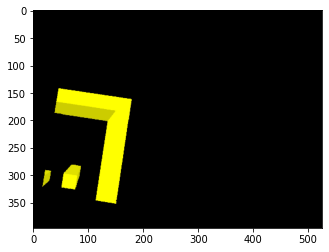

In [471]:
img1_in_2 = cv2.warpAffine(img1, M, img2.shape[:2][::-1])
show(img2)
show(img1_in_2)

[1 2 2 2 2 1 0 1 1 1 0 0 1 1 1 1]


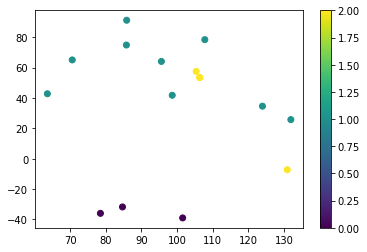

In [476]:
mask_biased = status[:,0].astype(bool)
indices_biased = np.repeat(np.arange(len(translations)), score_final)
mask = np.zeros(len(translations),dtype=int)
mask[indices_biased] = mask_biased + 1
print(mask)
plt.scatter(translations[:,0], translations[:,1], c=mask)
plt.colorbar()

[102.00259648  47.83600894]
[104.23214998  54.24085357]


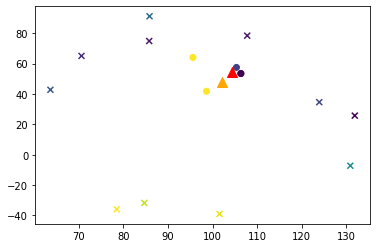

In [498]:
STD_RANGE = 0.5

center1 = np.average(translations, axis=0, weights=1/matches_dist)
dists = np.linalg.norm(translations - center1, axis=-1)
print(center1)

dist_std = np.sqrt(np.mean(dists**2))
mask = dists < STD_RANGE * dist_std
if not np.any(mask):
    mask[np.argmin(dists)] = True

center2 = np.average(translations, axis=0, weights=mask/matches_dist)
print(center2)

plt.scatter(translations[mask,0], translations[mask,1], c=matches_dist[mask])
plt.scatter(translations[~mask,0], translations[~mask,1], marker='x', c=matches_dist[~mask])
plt.scatter(*center1, marker='^', s=100, c='orange')
plt.scatter(*center2, marker='^', s=100, c='red')

In [529]:
centers = np.array([(50,140), (0,0)])
sizes = np.array([img1.shape, img2.shape])[:,1::-1]

min_pts = np.round(centers - sizes/2).astype(int)
max_pts = min_pts + sizes

min_pt = np.min(min_pts, axis=0)
max_pt = np.max(max_pts, axis=0)

print(min_pt, max_pt)

[-263 -198] [318 347]


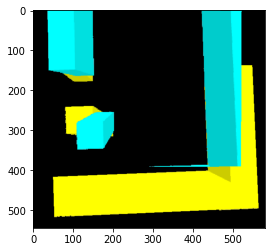

In [530]:
w,h = max_pt - min_pt
img_combined = np.zeros((h, w, 3), dtype=np.uint8)
for img,pt0,pt1 in zip([img1, img2[...,::-1]], min_pts, max_pts):
    mask = np.sum(img, axis=-1) > 0
    mask_broad = np.broadcast_to(mask[...,None], img.shape)
    x0, y0 = pt0 - min_pt
    x1, y1 = pt1 - min_pt
    view = img_combined[y0:y1,x0:x1]
    np.putmask(view, mask_broad, img)
show(img_combined)

In [9]:
from numpy.lib.stride_tricks import sliding_window_view as viewW
# https://stackoverflow.com/a/51613442
def strided_indexing_roll(a, r):
    # Concatenate with sliced to cover all rolls
    a_ext = np.concatenate((a, a[...,:-1]),axis=-1)

    # Get sliding windows; use advanced-indexing to select appropriate ones
    n = a.shape[-1]
    return viewW(a_ext,n,axis=-1)[(*np.indices(r.shape)), (n-r)%n]

In [21]:
data = {'images': [{'img': img1}, {'img': img2}]}

for d in data['images']:
    d['mask'] = np.sum(d['img'], axis=-1) > 0
    d['filt'] = d['mask'].astype(np.int8)

    d['axis'] = [{'name': 'y'}, {'name': 'x'}]
    for ax, a in enumerate(d['axis']):
        a['diff'] = np.diff(d['filt'], axis=ax)

        a['dir'] = [{'dir': 1}, {'dir': -1}]
        for dr in a['dir']:
            dr['mask'] = a['diff'] == dr['dir']
            dr['cum_nonaligned'] = np.cumsum(dr['mask'], axis=ax)
            dr['cum'] = dr['cum_nonaligned'].T if a['name'] == 'y' else dr['cum_nonaligned']
            dr['count'] = dr['cum'][:,-1]
            dr['maxcount'] = np.max(dr['count'])
            offs = np.arange(dr['cum'].shape[0]) * (dr['maxcount']+1)
            cumflat = (dr['cum'] + offs[:,None]).flat
            searchfor = offs[:,None] + np.arange(dr['maxcount']) + 1
            ss = np.searchsorted(cumflat, searchfor.flat)
            offs = np.arange(dr['cum'].shape[0]) * dr['cum'].shape[1]
            dr['indices'] = ss.reshape((dr['cum'].shape[0], dr['maxcount'])) - offs[:,None]

In [32]:
# https://stackoverflow.com/a/51240898
# Given a line with coordinates 'start' and 'end' and the
# coordinates of a point 'pnt' the proc returns the shortest 
# distance from pnt to the line and the coordinates of the 
# nearest point on the line.
#
# 1  Convert the line segment to a vector ('line_vec').
# 2  Create a vector connecting start to pnt ('pnt_vec').
# 3  Find the length of the line vector ('line_len').
# 4  Convert line_vec to a unit vector ('line_unitvec').
# 5  Scale pnt_vec by line_len ('pnt_vec_scaled').
# 6  Get the dot product of line_unitvec and pnt_vec_scaled ('t').
# 7  Ensure t is in the range 0 to 1.
# 8  Use t to get the nearest location on the line to the end
#    of vector pnt_vec_scaled ('nearest').
# 9  Calculate the distance from nearest to pnt_vec_scaled.
# 10 Translate nearest back to the start/end line. 
# Malcolm Kesson 16 Dec 2012
# Edited by Amit 21 Nov 2021
def pnt2line(pnt, start, end, clip=True):
    line_vec = end - start
    pnt_vec = pnt - start
    line_len = np.linalg.norm(line_vec,axis=-1)
    line_unitvec = line_vec / line_len[...,None]
    pnt_vec_scaled = pnt_vec / line_len[...,None]
    t = np.einsum('...i,...i', line_unitvec, pnt_vec_scaled)
    if clip:
        t = np.clip(t, 0.0, 1.0)
    nearest = line_vec * t[...,None]
    dist = np.linalg.norm(nearest - pnt_vec,axis=-1)
    return (dist, t)

[280.   0.   0.   0.   0.]
[348.   0.   0.   0.   0.]
[1. 0. 0. 0. 0.]
1e-06
68.0
[348.   0.   0.   0.   0.]
[18.  0.  0.  0.  0.]
[1. 0. 0. 0. 0.]
1e-06
-330.0
[384.   0.   0.   0.   0.]
[416.   0.   0.   0.   0.]
[1. 0. 0. 0. 0.]
1e-06
32.0
[416.   0.   0.   0.   0.]
[48.  0.  0.  0.  0.]
[1. 0. 0. 0. 0.]
1e-06
-368.0
y


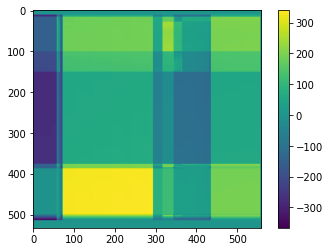

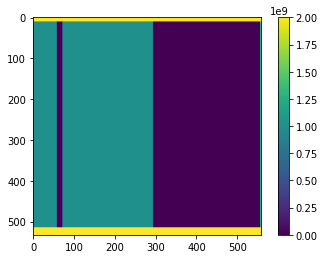

[377.   0.   0.]
[125.   0.   0.]
[1. 0. 0.]
1e-06
-252.0
[488.   0.   0.]
[377.   0.   0.]
[1. 0. 0.]
1e-06
-111.0
[499.   0.]
[214.   0.]
[1. 0.]
1e-06
-285.0
[557.   0.]
[499.   0.]
[1. 0.]
1e-06
-58.0
x


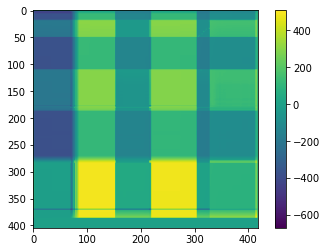

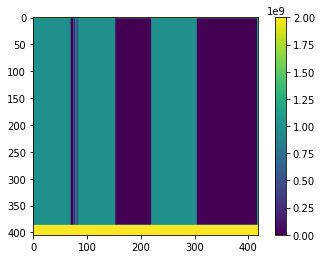

In [55]:
d1, d2 = data['images']
data['axis'] = [{'name': 'y'}, {'name': 'x'}]
for a, a1, a2 in zip(data['axis'], d1['axis'], d2['axis']):
    a['dir'] = [{'dir': 1}, {'dir': -1}]
    for dr, dr1, dr2 in zip(a['dir'], a1['dir'], a2['dir']):
        counts = np.stack(np.broadcast_arrays(dr1['count'][:,None], dr2['count'][None,:]))
        mincounts = np.min(counts, axis=0)
        mask1 = dr1['count'] > 0
        mask2 = dr2['count'] > 0
        numdims = min(dr1['maxcount'], dr2['maxcount'])
        vectors = (np.arange(numdims) < mincounts[...,None]).astype(float)
        vectors_masked = vectors[mask1][:,mask2]
        vectors_unit = vectors_masked / np.linalg.norm(vectors_masked, axis=-1)[...,None]

        dr['side'] = [{'name': 'left', 'coeff': 1}, {'name': 'right', 'coeff': -1}]
        for side in dr['side']:
            if side['name'] == 'left':
                countA = dr1['count'][mask1,None]
                ptsA = dr1['indices'][mask1,None]
                ptsB = dr2['indices'][None,mask2]
            else:
                countA = dr2['count'][None,mask2]
                ptsA = dr2['indices'][None,mask2]
                ptsB = dr1['indices'][mask1,None]

            pts_shape = vectors_masked.shape
            ptsA_shape = vectors_masked.shape[:2] + (ptsA.shape[-1],)

            roll = mincounts[mask1][:,mask2] - countA
            ptsA = strided_indexing_roll(np.broadcast_to(ptsA, ptsA_shape), roll)

            ptsA = ptsA[...,:numdims] * vectors_masked
            ptsB = ptsB[...,:numdims] * vectors_masked

            print(ptsA[50,50])
            print(ptsB[50,50])
            print(vectors_masked[50,50])

            side['loss'], side['dist'] = pnt2line(ptsB, ptsA, ptsA + vectors_unit, clip=False)
            side['loss'] = (side['loss'] ** 2).clip(1e-6, np.inf) # Squared loss

            print(side['loss'][50,50])
            print(side['dist'][50,50])

        losses = np.array([side['loss'] for side in dr['side']])
        dist = np.average([side['dist'] * side['coeff'] for side in dr['side']], axis=0, weights=1/losses)
        loss = np.sum(losses, axis=0)

        dr['dist'] = np.zeros(mincounts.shape)
        dr['loss'] = np.ones(mincounts.shape) * 1e9

        np.place(dr['dist'], mincounts > 0, dist)
        np.place(dr['loss'], mincounts > 0, loss)

    losses = np.array([dr['loss'] for dr in a['dir']])
    a['dist'] = np.average([dr['dist'] for dr in a['dir']], axis=0, weights=1/losses)
    a['loss'] = np.sum(losses, axis=0)

    print(a['name'])
    show(a['dist'], show=False)
    plt.colorbar()
    plt.show()

    show(a['loss'], show=False)
    plt.colorbar()
    plt.show()

## Using Masked Arrays:

In [22]:
def to_diag(pnts):
    "Return distance from point to diagonal and position on diagonal"
    vector = np.ones(pnts.shape[-1])
    counts = pnts.shape[-1] - np.ma.count_masked(pnts, axis=-1)
    line_len = np.sqrt(counts)
    t = np.ma.sum(pnts * vector, axis=-1) / line_len
    pt_dist_sq = np.ma.sum(pnts ** 2, axis=-1)
    dist_sq = pt_dist_sq - t**2
    return (dist_sq, t / line_len)

In [23]:
arr = np.ma.array([[1,1,1],[1,0,2],[-2,-3,999]],mask=[[False,False,False],[False,False,False],[False,False,True]])
to_diag(arr)

(masked_array(data=[-4.440892098500626e-16, 1.9999999999999996,
                    0.5000000000000018],
              mask=[False, False, False],
        fill_value=1e+20),
 masked_array(data=[1.0000000000000002, 1.0000000000000002,
                    -2.4999999999999996],
              mask=[False, False, False],
        fill_value=1e+20))

In [115]:
from numpy.lib.stride_tricks import sliding_window_view as viewW
# https://stackoverflow.com/a/51613442
def strided_indexing_roll(a, r):
    # Concatenate with sliced to cover all rolls
    a_ext = np.concatenate((a, a[...,:-1]),axis=-1)

    # Get sliding windows; use advanced-indexing to select appropriate ones
    n = a.shape[-1]
    arr_ret = viewW(a_ext,n,axis=-1)[(*np.indices(r.shape)), (n-r)%n]

    # Roll and apply mask too
    if np.ma.isMA(a):
        arr_ret = np.ma.array(arr_ret, mask=strided_indexing_roll(np.ma.getmaskarray(a), r), copy=False)
    return arr_ret

In [98]:
strided_indexing_roll(arr, np.array([1,0,-1]))

masked_array(
  data=[[1, 1, 1],
        [1, 0, 2],
        [-3, --, -2]],
  mask=[[False, False, False],
        [False, False, False],
        [False,  True, False]],
  fill_value=999999)

In [26]:
def diagonals(arr, k):
    length = np.min(arr.shape[:2])
    i = np.arange(length)
    j = (i[:,None] + k).T
    mask = (j < 0) | (j >= arr.shape[1])
    j[mask] = 0
    shp = np.concatenate([np.array(j.shape), np.array(arr.shape[2:])])
    shp_flat = shp.copy()
    shp_flat[2:] = 1
    mask_expanded = np.broadcast_to(mask.reshape(shp_flat), shp)
    return np.ma.array(arr[i,j], mask=mask_expanded)

In [27]:
# Convert to masked arrays
for d in data['images']:
    for ax, a in enumerate(d['axis']):
        for dr in a['dir']:
            dr['indices'] = np.ma.masked_where(np.arange(dr['maxcount']) >= dr['count'][:,None], dr['indices'], copy=False)

/tmp/ipykernel_199235/164870729.py:52: RuntimeWarning: divide by zero encountered in log
  a['score'] = -np.log(a['loss'])
/tmp/ipykernel_199235/164870729.py:52: RuntimeWarning: invalid value encountered in log
  a['score'] = -np.log(a['loss'])


607.5158100232752 169.96429505981578 46132.455554468135
490.55285892784127 110.83391745002774 86551.10110654014
482.24831290777814 110.83391745002774 84378.22692180639
473.79520633171694 110.83391745002774 82301.23780364466
465.2581325360247 110.83391745002774 82792.00985669575
453.65877737797155 110.83391745002774 80825.74440031865
442.25387009267416 110.83391745002774 78917.25670026816
430.5013975788156 110.83391745002774 79654.85192417906
422.5335855315058 110.83391745002774 78123.61867211165
411.44340680137753 110.83391745002774 76580.18055060212
395.38339367026134 110.83391745002774 75139.1973847379
386.9080185620686 110.83391745002774 73924.1148762508
374.9764758044588 110.83391745002774 72976.10053976113
363.9045685059258 110.83391745002774 73825.11236593506
364.39434848426555 110.83391745002774 73242.96198765113
347.7343589432009 110.83391745002774 75249.54773779788
337.7207956732958 110.83391745002774 74982.83417829938
333.691849776204 110.83391745002774 72319.12123856791


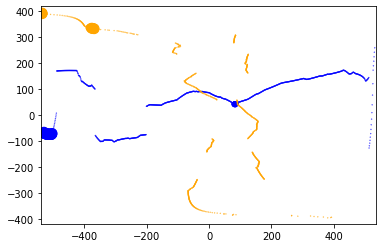

In [166]:
from scipy.spatial import KDTree
from scipy.sparse import lil_matrix

d1, d2 = data['images']
data['axis'] = [{'name': 'y'}, {'name': 'x'}]
for a, a1, a2 in zip(data['axis'], d1['axis'], d2['axis']):
    a['dir'] = [{'dir': 1}, {'dir': -1}]
    for dr, dr1, dr2 in zip(a['dir'], a1['dir'], a2['dir']):
        counts = np.stack(np.broadcast_arrays(dr1['count'][:,None], dr2['count'][None,:]))
        mincounts = np.min(counts, axis=0)
        numdims = min(dr1['maxcount'], dr2['maxcount'])

        dr['side'] = [{'name': 'left', 'coeff': 1}, {'name': 'right', 'coeff': -1}]
        for side in dr['side']:
            if side['name'] == 'left':
                countA = dr1['count'][:,None]
                ptsA = dr1['indices'][:,None]
                ptsB = dr2['indices'][None,:]
            else:
                countA = dr2['count'][None,:]
                ptsA = dr2['indices'][None,:]
                ptsB = dr1['indices'][:,None]

            pts_shape = mincounts.shape + (numdims,)
            ptsA_shape = mincounts.shape + (ptsA.shape[-1],)

            roll = mincounts - countA
            ptsA = strided_indexing_roll(np.broadcast_to(ptsA, ptsA_shape), roll)
            
            side['pts'] = ptsB[...,:numdims] - ptsA[...,:numdims]

        # Each side represents a different option
        dr['pts'] = np.ma.stack([side['pts'] * side['coeff'] for side in dr['side']])

    # Combine rising and falling into one test
    a['pts'] = np.ma.concatenate([dr['pts'] for dr in a['dir']], axis=-1)
    numdiags = np.max(a['pts'].shape[:2])
    offsets = np.arange(-numdiags, numdiags)
    diags = np.moveaxis(diagonals(np.moveaxis(a['pts'],0,2), offsets), 2, 0)
    pts_offset = diags.reshape(list(diags.shape[:-2])+[-1])
    numdims = pts_offset.shape[-1] - np.ma.count_masked(pts_offset, axis=-1)
    
    loss, dist = to_diag(pts_offset)

    loss = loss / np.sqrt(numdims) # Account for dimensionality (objective)
    loss /= numdims # Award for dimensionality (subjective)
    side = np.ma.argmin(loss, axis=0)

    a['dist'] = np.take_along_axis(dist, side[None,:], axis=0)[0]
    a['pts_offset'] = np.take_along_axis(pts_offset, side[None,:,None], axis=0)[0]
    a['loss'] = np.min(loss, axis=0)
    a['score'] = -np.log(a['loss'])

    pt_size = ((a['score'] + 5) * 100).clip(0.1,100)
    if a['name'] == 'y':
        plt.xlim([offsets[0], offsets[-1]])
        x, y = offsets, a['dist']
        plt.scatter(x, y, s=pt_size, c='blue')
    else:
        plt.ylim([offsets[0], offsets[-1]])
        x, y = a['dist'], offsets
        plt.scatter(x, y, s=pt_size, c='orange')
        
    a['coords'] = np.stack([x, y], axis=-1)
    a['tree'] = KDTree(a['coords'])

tree_vert, tree_horiz = (a['tree'] for a in data['axis'])
coords_vert, coords_horiz = (a['coords'] for a in data['axis'])
loss_vert, loss_horiz = (a['loss'] for a in data['axis'])
pts_vert, pts_horiz = (a['pts_offset'] for a in data['axis'])
matches = tree_horiz.query_ball_tree(tree_vert, 50, eps=0.1)

close_match = None
min_loss = np.inf
for verts, coord_horiz, err_horiz, features_horiz in zip(matches, coords_horiz, loss_horiz, pts_horiz):
    if len(verts) == 0 or np.ma.count_masked(coord_horiz) > 0:
        continue
    coord_vert = coords_vert[verts]
    features_vert = pts_vert[verts]
    err_vert = loss_vert[verts]
    dist_sq = np.sum((coord_vert - coord_horiz) ** 2)
    loss = (err_horiz * err_vert).clip(1,np.inf) * dist_sq
    min_idx = np.argmin(loss)
    
    min_loss_new = loss[min_idx]
    if min_loss_new < min_loss:
        print(err_horiz, err_vert[min_idx], dist_sq)
        min_loss = min_loss_new
        close_match = [features_vert[min_idx], features_horiz]

In [167]:
from sklearn.linear_model import RANSACRegressor
from sklearn.base import BaseEstimator

class DiagEstimator(BaseEstimator):
    def __init__(self, translation=0):
        self.translation = translation
    
    def fit(self, X, y):
        loss, self.translation = to_diag(y - X[:,0])

    def predict(self, X):
        return X[:,0] + self.translation

    def score(self, X, y):
        y_true = y
        y_pred = self.predict(X)
        u = ((y_true - y_pred) ** 2).sum()
        loss = u / np.sqrt(len(y_pred))
        score = -np.log(loss)
        return score

ransac = RANSACRegressor(base_estimator=DiagEstimator(), min_samples=1)
for a, feat in zip(data['axis'], close_match):
    y = feat[~feat.mask]
    X0 = np.zeros_like(y)[:,None]
    ransac.fit(X0, y)
    a['ransac'] = ransac.predict(np.array([[0]]))[0]

translation = [a['ransac'] for a in data['axis']][::-1]
translation

[74.05210084033612, 39.21145374449339]

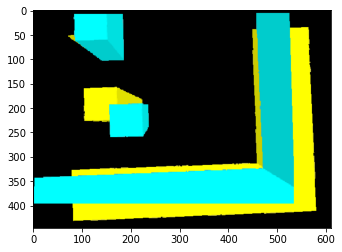

In [168]:
centers = np.array([translation, (0,0)])
sizes = np.array([img1.shape, img2.shape])[:,1::-1]

min_pts = np.round(centers - sizes/2).astype(int)
max_pts = min_pts + sizes

min_pt = np.min(min_pts, axis=0)
max_pt = np.max(max_pts, axis=0)

w,h = max_pt - min_pt
img_combined = np.zeros((h, w, 3), dtype=np.uint8)
for img,pt0,pt1 in zip([img1, img2[...,::-1]], min_pts, max_pts):
    mask = np.sum(img, axis=-1) > 0
    mask_broad = np.broadcast_to(mask[...,None], img.shape)
    x0, y0 = pt0 - min_pt
    x1, y1 = pt1 - min_pt
    view = img_combined[y0:y1,x0:x1]
    np.putmask(view, mask_broad, img)
show(img_combined)

In [113]:
from sensor_msgs.msg import CompressedImage
def capture_compressed():
    return rospy.wait_for_message('/main_camera/image_raw/compressed', CompressedImage, timeout=1.)
bridge.compressed_imgmsg_to_cv2(capture_compressed(),desired_encoding='bgr8').shape

(240, 320, 3)

## Initial guess and RANSAC

In [176]:
guess = np.array([70,40])

ransac = RANSACRegressor(base_estimator=DiagEstimator(), min_samples=1)

d1, d2 = data['images']
data['axis'] = [{'name': 'y'}, {'name': 'x'}]
for a, a1, a2, offs, guess_ax in zip(data['axis'], d1['axis'], d2['axis'], guess, guess[::-1]):
    a['dir'] = [{'dir': 1}, {'dir': -1}]
    for dr, dr1, dr2 in zip(a['dir'], a1['dir'], a2['dir']):
        # Prepare offset ranges
        range1 = np.array([0, len(dr1['indices'])])
        range2 = range1 + offs
        ranges = np.stack([range1, range2])
        ranges[:,0] += max(0, -ranges[1,0])
        ranges[:,1] -= max(0, ranges[1,1]-len(dr2['indices']))
        
        start1, end1 = ranges[0]
        start2, end2 = ranges[1]
        
        counts = np.stack([dr1['count'][start1:end1], dr2['count'][start2:end2]])
        mincounts = np.min(counts, axis=0)
        numdims = np.min(np.max(counts, axis=-1))

        pts1 = dr1['indices'][start1:end1]
        pts2 = dr2['indices'][start2:end2]

        def rollback(ptsX, countX):
            ptsX_shape = mincounts.shape + (ptsX.shape[-1],)
            roll = mincounts - countX
            return strided_indexing_roll(np.broadcast_to(ptsX, ptsX_shape), roll)

        if guess_ax < 0:
            # If we guess negative in this axis, then rollback pts1 to match (we might have unmatched entries at start of pts1)
            pts1 = rollback(pts1, counts[0])
        else:
            pts2 = rollback(pts2, counts[1])
            
        dr['pts'] = pts2[...,:numdims] - pts1[...,:numdims]

    # Combine rising and falling into one test
    a['pts'] = np.ma.concatenate([dr['pts'] for dr in a['dir']], axis=-1)

    y = a['pts'][~a['pts'].mask]
    X0 = np.zeros_like(y)[:,None]
    ransac.fit(X0, y)
    a['dist'] = ransac.predict(np.array([[0]]))[0]
    a['score'] = ransac.score(X0, y)

translation = np.array([a['dist'] for a in data['axis']][::-1])
translation

array([78.14972274, 17.09223847])

In [175]:
np.ma.array([[1,2],[3,4]],mask=[[False,True],[True,False]]).reshape(-1)

masked_array(data=[1, --, --, 4],
             mask=[False,  True,  True, False],
       fill_value=999999)